# Waveguide coupler (layout and simulation)

The step by step process is the same as the previous notebook:
1. Draw a waveguide coupler and save it in a .gds file.
2. Load the layout using Meep.
3. Setup simulation environment.
4. Simulate FDTD and visualize results.
5. Compute S-parameters of the coupler.

## Why is this important?

- FDTD simulations take a long time.
- This can be compensated by breaking up the simulation in smaller parts
- For example, in order to simulate an add-drop microring resonator, we can break it up in bent waveguides and couplers, like in the image below.
!['Add/Drop Microring Resonator'](images/add_drop_ring.svg)

Last notebook, we simulated a bent waveguide and captured the results in an S-matrix. In this notebook, we will simulate the waveguide coupler. After that, the S-matrices can be used together to compute the response of the microring resonator.

## Simulation 1

- This device has 4 ports, and therefore it will require a 4x4 S-matrix. 
- It will take multiple FDTD simulations in order to obtain the full 4x4 S matrix.
- For example, consider the following source/port configuration:
<img alt="Waveguide coupler with source at port 1" src="images/waveguide_coupler_source1.svg" style="width: 50%">
- Each simulation ordinarily yields 4 S-numbers, but because of the symmetry of this device, the S values upon swapping ports 1↔3 and 2↔4 should remain the same. For example, $S_{23} = S_{41}$ for all frequencies.

In this notebook, we will prepare an FDTD simulation with the source at port 1.

In [1]:
# Import meep and mpb (from meep)
import meep as mp
from meep import mpb

# arrays
import numpy as np

# plotting
import matplotlib.pyplot as plt

# Debug info
print("Meep version:", mp.__version__)

Using MPI version 3.1, 1 processes
Meep version: 1.12.0


In [2]:
import pya
import numpy as np

SIM_CELL = pya.LayerInfo(0, 0)
Si = pya.LayerInfo(1, 0)
MEEP_SOURCE = pya.LayerInfo(10, 0)
MEEP_PORT1 = pya.LayerInfo(20, 0)
MEEP_PORT2 = pya.LayerInfo(21, 0)
MEEP_PORT3 = pya.LayerInfo(22, 0)
MEEP_PORT4 = pya.LayerInfo(23, 0)

## Simulation Parameters

In [3]:
ring_radius = 8 # um
ring_width = 0.5 # um
pml_width = 1.0 # um
gap = 0.2 # um
src_port_gap = 0.2 # um
straight_wg_length = pml_width + 1 # um

# Simulation resolution
res = 100        # pixels/μm

## Step 1. Drawing a waveguide coupler and saving into a temporary .gds file

In [4]:
from zeropdk.layout import layout_arc, layout_waveguide, layout_path, layout_box
from tempfile import NamedTemporaryFile
from math import sqrt

# Create a temporary filename
temp_file = NamedTemporaryFile(delete=False, suffix='.gds')
filename = temp_file.name
# temp_file = None
# filename = "test.gds"

# Clean existing file
!rm {filename}

# Instantiate a layout and a top cell
layout = pya.Layout()
layout.dbu = 0.001
TOP = layout.create_cell("TOP")

sqrt2 = sqrt(2)

# Unit vectors
ex = pya.DVector(1, 0)
ey = pya.DVector(0, 1)
e45 = (ex + ey) / sqrt2
e135 = (-ex + ey) / sqrt2

# Draw circular bend
layout_arc(TOP, Si, - ring_radius*ey, ring_radius, ring_width, 0, np.pi/2)

# Extend the bend to avoid discontinuities
layout_waveguide(TOP, Si, [0*ex, - straight_wg_length*ex], ring_width)
layout_waveguide(TOP, Si, [-1*ring_radius*ey + ring_radius*ex, 
                           -straight_wg_length * ey - ring_radius*ey + ring_radius*ex], ring_width)

# Add the ports as 0-width paths
port_size = ring_width * 4.0


# Draw add/drop waveguide

coupling_point = (ring_radius + gap + ring_width) * e45 - ring_radius * ey
add_drop_length = (ring_radius + gap + ring_width) * sqrt2
layout_waveguide(TOP, Si, [coupling_point + (add_drop_length + 0.4) * e135,
                           coupling_point - (add_drop_length + 0.4) * e135],
                ring_width)


# Source at port 1
layout_path(TOP, MEEP_SOURCE, [coupling_point - port_size/2*ex + (add_drop_length / 2 + src_port_gap) * e135, 
                               coupling_point + port_size/2*ex + (add_drop_length / 2 + src_port_gap) * e135], 0)

# Source at port 2 (alternative)
# layout_path(TOP, MEEP_SOURCE, [-port_size/2*ey - src_port_gap*ex, port_size/2*ey - 0.2*ex], 0)

# Port 1
layout_path(TOP, MEEP_PORT1,   [coupling_point - port_size/2*ex + (add_drop_length / 2) * e135, 
                                coupling_point + port_size/2*ex  + (add_drop_length / 2) * e135], 0)

# Port 2
layout_path(TOP, MEEP_PORT2,   [-port_size/2*ey, port_size/2*ey], 0)

# Port 3
layout_path(TOP, MEEP_PORT3,   [coupling_point - port_size/2*ey - (add_drop_length / 2) * e135, 
                                coupling_point + port_size/2*ey - (add_drop_length / 2) * e135], 0)
# Port 4
layout_path(TOP, MEEP_PORT4,   [-1*ring_radius*ey + ring_radius*ex - port_size/2*ex, 
                                -1*ring_radius*ey + ring_radius*ex + port_size/2*ex], 0)

# Draw simulation region
layout_box(TOP, SIM_CELL, 
           -1.0*ring_radius*ey - (pml_width + src_port_gap) * (ex + ey), # Bottom left point 
           coupling_point + (add_drop_length / 2 + src_port_gap) * e45 + pml_width * (ex + ey),  # Top right point
           ex)

# Write to file
layout.write(filename)
layout.write('test.gds')
print(f"Produced file {filename}.")
!ls -lh {filename}

Produced file /tmp/tmp2fjj9anx.gds.
-rw-r--r-- 1 tlima grad 2.5K Feb 25 21:34 /tmp/tmp2fjj9anx.gds


## Step 2. Load gds file into meep

### Visualization and simulation

If you choose a normal filename (not temporary), you can download the GDSII file from the cluster (see Files in MyAdroit dashboard) to see it with your local Klayout. Otherwise, let's get simulating:

In [5]:
def round_vector(vector, decimal_places=3):
    x = round(vector.x, decimal_places)
    y = round(vector.y, decimal_places)
    z = round(vector.z, decimal_places)
    return mp.Vector3(x, y, z)

In [6]:
gdsII_file = filename
CELL_LAYER = 0
SOURCE_LAYER = 10
Si_LAYER = 1
PORT1_LAYER = 20
PORT2_LAYER = 21
PORT3_LAYER = 22
PORT4_LAYER = 23

t_oxide = 1.0
t_Si = 0.22
t_SiO2 = 0.78

oxide = mp.Medium(epsilon=2.25)
silicon=mp.Medium(epsilon=12)

lcen = 1.55
fcen = 1/lcen
df = 0.2*fcen
nfreq = 25

cell_zmax =  0
cell_zmin =  0
si_zmax = 10
si_zmin = -10

# read cell size, volumes for source region and flux monitors,
# and coupler geometry from GDSII file
# WARNING: Once the file is loaded, the prism contents is cached and cannot be reloaded.
# SOLUTION: Use a different filename or restart the kernel

si_layer = mp.get_GDSII_prisms(silicon, gdsII_file, Si_LAYER, si_zmin, si_zmax)

cell = mp.GDSII_vol(gdsII_file, CELL_LAYER, cell_zmin, cell_zmax)
src_vol = mp.GDSII_vol(gdsII_file, SOURCE_LAYER, si_zmin, si_zmax)
p1 = mp.GDSII_vol(gdsII_file, PORT1_LAYER, si_zmin, si_zmax)
p2 = mp.GDSII_vol(gdsII_file, PORT2_LAYER, si_zmin, si_zmax)
p3 = mp.GDSII_vol(gdsII_file, PORT3_LAYER, si_zmin, si_zmax)
p4 = mp.GDSII_vol(gdsII_file, PORT4_LAYER, si_zmin, si_zmax)


sources = [mp.EigenModeSource(src=mp.GaussianSource(fcen,fwidth=df),
                              size=round_vector(src_vol.size),
                              center=round_vector(src_vol.center),
                              direction=mp.NO_DIRECTION,
                              eig_kpoint=mp.Vector3(1, -1, 0), # -45 degree angle
                              eig_band=1,
                              eig_parity=mp.NO_PARITY,
                              eig_match_freq=True)]

# Display simulation object
sim = mp.Simulation(resolution=res,
                    default_material=oxide,
                    eps_averaging=False,
                    cell_size=cell.size,
                    geometry_center=round_vector(cell.center,2),
                    boundary_layers=[mp.PML(pml_width)],
                    sources=sources,
                    geometry=si_layer)

# Delete file created in previous cell

import os
if temp_file:
    temp_file.close()
    os.unlink(filename)

## Step 3. Setup simulation environment

This will load the python-defined parameters from the previous cell and instantiate a fast, C++ based, simulation environment using meep. It will also compute the eigenmode of the source, in preparation for the FDTD simulation.

In [7]:
sim.reset_meep()

# Could add monitors at many frequencies by looping over fcen
# Means one FDTD for many results!
mode1 = sim.add_mode_monitor(fcen, df, nfreq, mp.ModeRegion(volume=p1))
mode2 = sim.add_mode_monitor(fcen, df, nfreq, mp.ModeRegion(volume=p2))
mode3 = sim.add_mode_monitor(fcen, df, nfreq, mp.ModeRegion(volume=p3))
mode4 = sim.add_mode_monitor(fcen, df, nfreq, mp.ModeRegion(volume=p4))

# Let's store the frequencies that were generated by this mode monitor
mode1_freqs = np.array(mp.get_eigenmode_freqs(mode1))
mode2_freqs = np.array(mp.get_eigenmode_freqs(mode2))
mode3_freqs = np.array(mp.get_eigenmode_freqs(mode3))
mode4_freqs = np.array(mp.get_eigenmode_freqs(mode4))

sim.init_sim()

-----------
Initializing structure...
time for choose_chunkdivision = 0.00047493 s
Working in 2D dimensions.
Computational cell is 12.84 x 12.84 x 0 with resolution 100
     prism, center = (5.11221,-2.88779,0)
          height 20, axis (0,0,1), 228 vertices:
          (7.75,-8,-10)
          (7.748,-7.81,-10)
          (7.745,-7.715,-10)
          (7.741,-7.62,-10)
          (7.729,-7.43,-10)
          (7.713,-7.24,-10)
          (7.703,-7.146,-10)
          (7.692,-7.051,-10)
          (7.666,-6.863,-10)
          (7.652,-6.769,-10)
          (7.636,-6.675,-10)
          (7.619,-6.581,-10)
          (7.601,-6.488,-10)
          (7.582,-6.395,-10)
          (7.562,-6.302,-10)
          (7.54,-6.209,-10)
          (7.518,-6.117,-10)
          (7.494,-6.025,-10)
          (7.469,-5.933,-10)
          (7.443,-5.841,-10)
          (7.416,-5.75,-10)
          (7.388,-5.659,-10)
          (7.359,-5.569,-10)
          (7.297,-5.389,-10)
          (7.231,-5.211,-10)
          (7.196,-5.122,-1

### Verify if there are numerical errors.
- You should see a clean black and white plot.
- If there are other weird structures, try increasing the resolution.

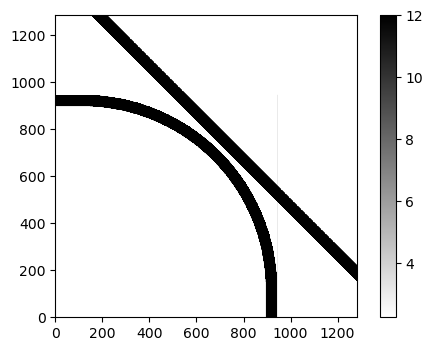

In [8]:
eps_data = sim.get_array(center=cell.center, size=cell.size, component=mp.Dielectric)
plt.figure(dpi=res)
plt.imshow(eps_data.transpose(), interpolation='none', cmap='binary', origin='lower')
plt.colorbar()
plt.show()

### Verify that the structure makes sense.

Things to check:
- Are the sources and ports outside the PML?
- Are dimensions correct?
- Is the simulation region unnecessarily large?

/home/ELE559/anaconda3/envs/all_tools/lib/python3.7/site-packages/meep/visualization.py:197: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn('The specified user volume is larger than the simulation domain and has been truncated.')


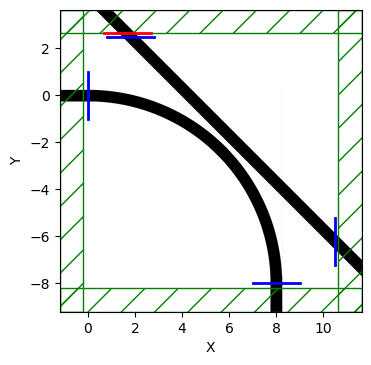

In [9]:
# If there is a warning that reads "The specified user volume
# is larger than the simulation domain and has been truncated",
# It has to do with some numerical errors between python and meep.
# Ignore.
# sim.init_sim()

f = plt.figure(dpi=100)
sim.plot2D(ax=f.gca())
plt.show()

Looks pretty good. Simulations at the high enough resolution required to avoid spurious reflections in the bend are very slow! This can be sped up quite a bit by running the code in parallel from the terminal. Later, we will put this notebook's code into a script and run it in parallel.

## Step 4. Simulate FDTD and Animate results

More detailed meep documentation available [here](https://meep.readthedocs.io/en/latest/Python_Tutorials/Basics/#transmittance-spectrum-of-a-waveguide-bend).

In [10]:
# Set to true to compute animation (may take a lot of memory)
# Turn this off if you don't need to visualize.
compute_animation = True

In [11]:
# Setup and run the simulation

# The following line defines a stopping condition depending on the square
# of the amplitude of the Ez field at the port 2.
print(f"Stop condition: decay to 0.1% of peak value in the last {2.0/df:.1f} time units.")
stop_condition = mp.stop_when_fields_decayed(2.0/df,mp.Ez,p3.center,1e-3)
if compute_animation:
    f = plt.figure(dpi=100)
    animate = mp.Animate2D(sim,mp.Ez,f=f,normalize=True)
    sim.run(mp.at_every(1,animate), until_after_sources=stop_condition)
    plt.close()
    animate.to_mp4(10, 'media/coupler1.mp4')
else:
    sim.run(until_after_sources=stop_condition)

Stop condition: decay to 0.1% of peak value in the last 15.5 time units.


/home/ELE559/anaconda3/envs/all_tools/lib/python3.7/site-packages/meep/visualization.py:197: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn('The specified user volume is larger than the simulation domain and has been truncated.')


on time step 200 (time=1), 0.0480151 s/step


/home/ELE559/anaconda3/envs/all_tools/lib/python3.7/site-packages/meep/visualization.py:197: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn('The specified user volume is larger than the simulation domain and has been truncated.')


on time step 421 (time=2.105), 0.0181264 s/step
on time step 642 (time=3.21), 0.0181154 s/step
on time step 863 (time=4.315), 0.0181333 s/step
on time step 1084 (time=5.42), 0.0181441 s/step
on time step 1305 (time=6.525), 0.0181656 s/step
on time step 1526 (time=7.63), 0.0181557 s/step
on time step 1747 (time=8.735), 0.0181725 s/step
on time step 1968 (time=9.84), 0.0181631 s/step
on time step 2189 (time=10.945), 0.0181694 s/step
on time step 2405 (time=12.025), 0.0185297 s/step
on time step 2626 (time=13.13), 0.0181558 s/step
on time step 2847 (time=14.235), 0.0181263 s/step
on time step 3068 (time=15.34), 0.0181293 s/step
field decay(t = 15.505): 1.0580805029501527e-227 / 1.0580805029501527e-227 = 1.0
on time step 3289 (time=16.445), 0.0181516 s/step
on time step 3511 (time=17.555), 0.0180951 s/step
on time step 3733 (time=18.665), 0.0180954 s/step
on time step 3955 (time=19.775), 0.0180908 s/step
on time step 4176 (time=20.88), 0.0181005 s/step
on time step 4398 (time=21.99), 0.018

### Visualize results

Things to check:
- Was the simulation time long enough for the pulse to travel through the output port in its entirety? Given the automatic stop condition, this should be the case.

In [12]:
from IPython.display import Video, display
if compute_animation:
    display(Video('media/coupler1.mp4'))

## Step 5. Compute S parameters of the coupler

In [13]:
# Every mode monitor measures the power flowing through it in either the forward or backward direction

# This time, the monitor is at an oblique angle to the waveguide. This is because meep
# can only compute fluxes in either the x, y, or z planes. In order to correctly measure
# the flux, we need to provide a k-vector at an angle. 
# So we compute a unit vector at a -45 angle like so:
kpoint135 = mp.Vector3(x=1).rotate(mp.Vector3(z=1), np.radians(-45))

# In this simulation, the ports 1 and 3 are on an angled waveguide, and
# 2 and 4 are perpendicular to the waveguide.
eig_mode1 = sim.get_eigenmode_coefficients(mode1, [1], eig_parity=mp.NO_PARITY, 
                                           direction=mp.NO_DIRECTION, kpoint_func=lambda f,n: kpoint135)

eig_mode2 = sim.get_eigenmode_coefficients(mode2, [1], eig_parity=mp.NO_PARITY)

eig_mode3 = sim.get_eigenmode_coefficients(mode3, [1], eig_parity=mp.NO_PARITY, 
                                           direction=mp.NO_DIRECTION, kpoint_func=lambda f,n: kpoint135)

eig_mode4 = sim.get_eigenmode_coefficients(mode4, [1], eig_parity=mp.NO_PARITY)

# We proceed like last time.

# First, we need to figure out which direction the "dominant planewave" k-vector is
# We can pick the first frequency (0) for that, assuming that for all simulated frequencies,
# The dominant k-vector will point in the same direction.
k1 = eig_mode1.kdom[0]
k2 = eig_mode2.kdom[0]
k3 = eig_mode3.kdom[0]
k4 = eig_mode4.kdom[0]

# eig_mode.alpha[0,0,0] corresponds to the forward direction, whereas
# eig_mode.alpha[0,0,1] corresponds to the backward direction

# For port 1, we are interested in the -y direction, so if k1.y is positive, select 1, otherwise 0
idx = (k1.y > 0) * 1
p1_thru_coeff = eig_mode1.alpha[0,:,idx]
p1_reflected_coeff = eig_mode1.alpha[0,:,1-idx]

# For port 3, we are interestred in the +x direction
idx = (k3.x < 0) * 1
p3_thru_coeff = eig_mode3.alpha[0,:,idx]
p3_reflected_coeff = eig_mode3.alpha[0,:,1-idx]

# For port 2, we are interested in the -x direction
idx = (k2.x > 0) * 1
p2_thru_coeff = eig_mode2.alpha[0,:,idx]
p2_reflected_coeff = eig_mode2.alpha[0,:,1-idx]

# For port 4, we are interested in the -y direction
idx = (k4.y > 0) * 1
p4_thru_coeff = eig_mode4.alpha[0,:,idx]
p4_reflected_coeff = eig_mode4.alpha[0,:,1-idx]


# transmittance
S41 = p4_thru_coeff/p1_thru_coeff
S31 = p3_thru_coeff/p1_thru_coeff
S21 = p2_thru_coeff/p1_thru_coeff
S11 = p1_reflected_coeff/p1_thru_coeff

print("----------------------------------")
print(f"Parameters: radius={ring_radius:.1f}")
print(f"Frequencies: {mode1_freqs}")

MPB solved for omega_1(0.707107,-1.41421,0) = 0.338074 after 17 iters
MPB solved for omega_1(1.31751,-2.63501,0) = 0.578599 after 10 iters
MPB solved for omega_1(1.32269,-2.64538,0) = 0.580645 after 7 iters
MPB solved for omega_1(1.32269,-2.64538,0) = 0.580645 after 1 iters
Dominant planewave for band 1: (1.322692,-1.322692,0.000000)
MPB solved for omega_1(0.707107,-1.41421,0) = 0.338074 after 18 iters
MPB solved for omega_1(1.33103,-2.66207,0) = 0.583938 after 11 iters
MPB solved for omega_1(1.33631,-2.67263,0) = 0.586022 after 7 iters
MPB solved for omega_1(1.33631,-2.67263,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (1.336314,-1.336314,0.000000)
MPB solved for omega_1(0.707107,-1.41421,0) = 0.338074 after 15 iters
MPB solved for omega_1(1.34456,-2.68913,0) = 0.589278 after 11 iters
MPB solved for omega_1(1.34993,-2.69987,0) = 0.591398 after 7 iters
MPB solved for omega_1(1.34993,-2.69987,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (1.349934,-1.349934,0.

MPB solved for omega_1(1.64883,-3.29766,0) = 0.709677 after 1 iters
Dominant planewave for band 1: (1.648828,-1.648828,0.000000)
MPB solved for omega_1(2.01141,0,0) = 0.618698 after 26 iters
MPB solved for omega_1(1.87532,0,0) = 0.580676 after 10 iters
MPB solved for omega_1(1.87521,0,0) = 0.580645 after 4 iters
MPB solved for omega_1(1.87521,0,0) = 0.580645 after 1 iters
Dominant planewave for band 1: (1.875210,-0.000000,0.000000)
MPB solved for omega_1(2.03004,0,0) = 0.623906 after 31 iters
MPB solved for omega_1(1.89458,0,0) = 0.586052 after 10 iters
MPB solved for omega_1(1.89447,0,0) = 0.586022 after 4 iters
MPB solved for omega_1(1.89447,0,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (1.894467,-0.000000,0.000000)
MPB solved for omega_1(2.04866,0,0) = 0.629115 after 32 iters
MPB solved for omega_1(1.91383,0,0) = 0.591428 after 10 iters
MPB solved for omega_1(1.91372,0,0) = 0.591398 after 4 iters
MPB solved for omega_1(1.91372,0,0) = 0.591398 after 1 iters
Dominant pl

MPB solved for omega_1(2.67263,-1.33631,0) = 0.586022 after 7 iters
MPB solved for omega_1(2.67263,-1.33631,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (1.336314,-1.336314,0.000000)
MPB solved for omega_1(1.41421,-0.707107,0) = 0.338074 after 16 iters
MPB solved for omega_1(2.68913,-1.34456,0) = 0.589278 after 11 iters
MPB solved for omega_1(2.69987,-1.34993,0) = 0.591398 after 7 iters
MPB solved for omega_1(2.69987,-1.34993,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (1.349934,-1.349934,0.000000)
MPB solved for omega_1(1.41421,-0.707107,0) = 0.338074 after 19 iters
MPB solved for omega_1(2.71618,-1.35809,0) = 0.594619 after 11 iters
MPB solved for omega_1(2.7271,-1.36355,0) = 0.596774 after 7 iters
MPB solved for omega_1(2.7271,-1.36355,0) = 0.596774 after 1 iters
Dominant planewave for band 1: (1.363551,-1.363551,0.000000)
MPB solved for omega_1(1.41421,-0.707107,0) = 0.338074 after 18 iters
MPB solved for omega_1(2.74324,-1.37162,0) = 0.599961 after 11 

MPB solved for omega_1(0,2.03004,0) = 0.623906 after 29 iters
MPB solved for omega_1(0,1.89458,0) = 0.586052 after 7 iters
MPB solved for omega_1(0,1.89447,0) = 0.586022 after 3 iters
MPB solved for omega_1(0,1.89447,0) = 0.586022 after 1 iters
Dominant planewave for band 1: (0.000000,1.894467,0.000000)
MPB solved for omega_1(0,2.04866,0) = 0.629115 after 30 iters
MPB solved for omega_1(0,1.91383,0) = 0.591428 after 7 iters
MPB solved for omega_1(0,1.91372,0) = 0.591398 after 3 iters
MPB solved for omega_1(0,1.91372,0) = 0.591398 after 1 iters
Dominant planewave for band 1: (0.000000,1.913720,0.000000)
MPB solved for omega_1(0,2.06729,0) = 0.634325 after 32 iters
MPB solved for omega_1(0,1.93307,0) = 0.596804 after 7 iters
MPB solved for omega_1(0,1.93297,0) = 0.596774 after 3 iters
MPB solved for omega_1(0,1.93297,0) = 0.596774 after 1 iters
Dominant planewave for band 1: (0.000000,1.932968,0.000000)
MPB solved for omega_1(0,2.08591,0) = 0.639536 after 21 iters
MPB solved for omega_1(

In [14]:
S11_mag = np.abs(S11)
S11_phase = np.unwrap(np.angle(S11))

S21_mag = np.abs(S21)
S21_phase = np.unwrap(np.angle(S21))

S31_mag = np.abs(S31)
S31_phase = np.unwrap(np.angle(S31))

S41_mag = np.abs(S41)
S41_phase = np.unwrap(np.angle(S41))

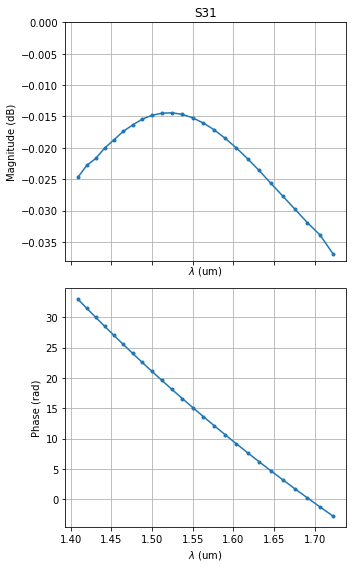

In [15]:
# Plot S21
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S31_mag), '.-')
ax1.set_title("S31")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S31_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

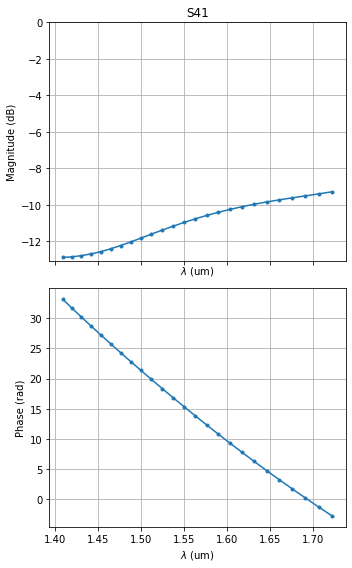

In [16]:
# Plot S41
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S41_mag), '.-')
ax1.set_title("S41")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S41_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

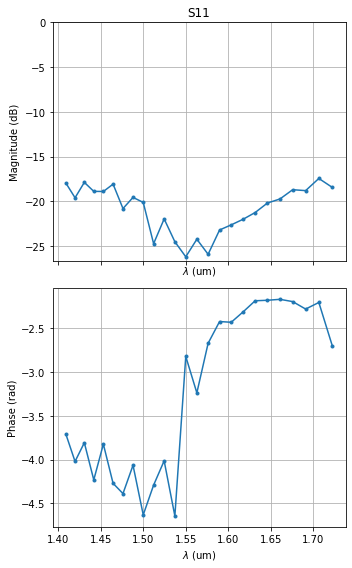

In [17]:
# Plot S11
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S11_mag), '.-')
ax1.set_title("S11")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S11_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

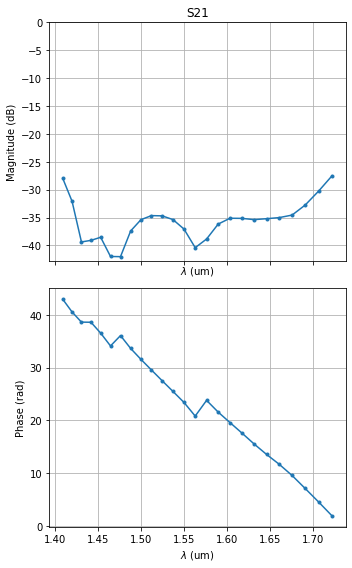

In [18]:
# Plot S21
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5, 8))
ax1.plot(1/mode1_freqs, 10 * np.log10(S21_mag), '.-')
ax1.set_title("S21")
ax1.set_xlabel(r"$\lambda$ (um)")
ax1.set_ylabel("Magnitude (dB)")
ax1.set_ylim(None, 0)
ax1.grid()

ax2.plot(1/mode1_freqs, S21_phase, '.-')
ax2.set_xlabel(r"$\lambda$ (um)")
ax2.set_ylabel("Phase (rad)")
ax2.grid()
plt.tight_layout()

In [20]:
#Write to csv file
import csv
with open(f'sparams1.gap{gap:.2f}um.csv', mode='w') as sparams_file:
    sparam_writer = csv.writer(sparams_file, delimiter=',')
    sparam_writer.writerow(['f(Hz)',
                            'real(S11)','imag(S11)',
                            'real(S21)','imag(S21)',
                            'real(S31)','imag(S31)',
                            'real(S41)','imag(S41)'
                           ])
    for i in range(len(mode1_freqs)):
        sparam_writer.writerow([mode1_freqs[i] * 3e14,
                                np.real(S11[i]),np.imag(S11[i]),
                                np.real(S21[i]),np.imag(S21[i]),
                                np.real(S31[i]),np.imag(S31[i]),
                                np.real(S41[i]),np.imag(S41[i])
                               ])

# Milestones | Simulation 2

Goal 1: Adapt this notebook to compute the remaining S-matrices, in particular $S_{x2}$.

Tip: You will need to change the location of the source, per the figure below:
<img alt="Waveguide coupler with source at port 1" src="images/waveguide_coupler_source2.svg" style="width: 50%">

Goal 2: Compute the S-parameters for a bend radius of 8 um and varying gaps between 150nm and 300nm.

- Q: We define coupling ratio by two parameters: r (cross) and t (bar). In this example, $S_{31}$ represents $t$ and $S_{41}$ represents $r$. For a lossless coupler, the following formula should hold: $|r|^2 + |t|^2 = 1$. Does it hold here? If it doesn't, where do you think the losses are coming from?

- Q: Even though this is not a symmetrical device in $y$, since most of the coupling happens around a single point, many people model it as a device with double mirror symmetry, like the directional coupler. This would imply that, additionally to the symmetries we explored, we would have $S_{31} = S_{42} = t$ and $S_{41} = S_{32} = r$. Compare them and comment.

## Automation

Repeat the steps of the last notebook. For your convenience, we have created the file `waveguide_point_coupler.py` with the contents of this notebook. Good luck!